In [1]:
import torch
print(torch.__version__)
torch.manual_seed(32)

2.1.2+cu121


Module is the basic unit of composition in PyTorch. It contains:

A constructor, which prepares the module for invocation

A set of Parameters and sub-Modules. These are initialized by the constructor and can be used by the module during invocation.

A forward function. This is the code that is run when the module is invoked.

In [3]:
class MyCell(torch.nn.Module):
    def __init__(self):  # constructor
        super(MyCell, self).__init__()

    def forward(self, x , h):  # forward method
        new_h = torch.tanh(x + h)
        return new_h, new_h

In [5]:
my_cell = MyCell()
x = torch.rand(3, 4)
y = torch.rand(3, 4)  # 3r 4c tensor
print(my_cell(x, y))

(tensor([[0.9021, 0.6781, 0.2603, 0.7710],
        [0.3570, 0.8511, 0.7331, 0.6994],
        [0.7316, 0.7919, 0.6576, 0.5630]]), tensor([[0.9021, 0.6781, 0.2603, 0.7710],
        [0.3570, 0.8511, 0.7331, 0.6994],
        [0.7316, 0.7919, 0.6576, 0.5630]]))


In [13]:
class MyLinCell(torch.nn.Module):
    # We are building a hierarchy of Modules.
    def __init__(self):
        super(MyLinCell, self).__init__()
        self.lin = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.lin(x) + h)
        return new_h, new_h

In [15]:
new_cell = MyLinCell()
print(new_cell)

MyLinCell(
  (lin): Linear(in_features=4, out_features=4, bias=True)
)


In [16]:
new_cell(x, y)

(tensor([[ 0.5944,  0.5390, -0.1090,  0.3791],
         [ 0.2142,  0.7751,  0.2864, -0.3191],
         [ 0.1676,  0.8363, -0.0080, -0.5167]], grad_fn=<TanhBackward0>),
 tensor([[ 0.5944,  0.5390, -0.1090,  0.3791],
         [ 0.2142,  0.7751,  0.2864, -0.3191],
         [ 0.1676,  0.8363, -0.0080, -0.5167]], grad_fn=<TanhBackward0>))

In [27]:
class MyDecision(torch.nn.Module):
    def forward(self, x):
        if x.sum() > 0:
            return x
        else:
            return -x
        
class MyDecCell(torch.nn.Module):
    def __init__(self, dg):
        super(MyDecCell, self).__init__()
        self.dg = MyDecision()
        self.lin = torch.nn.Linear(4, 4)


    def forward(self, x, h):
        new_h = torch.tanh(self.dg(self.lin(x)) + h)
        return new_h, new_h

In [28]:
mygate = MyDecision()
dec_cell = MyDecCell(mygate)
print(dec_cell)

MyDecCell(
  (dg): MyDecision()
  (lin): Linear(in_features=4, out_features=4, bias=True)
)


Many frameworks take the approach of computing symbolic derivatives given a full program representation. However, in PyTorch, we use a gradient tape. We record operations as they occur, and replay them backwards in computing derivatives. In this way, the framework does not have to explicitly define derivatives for all constructs in the language.

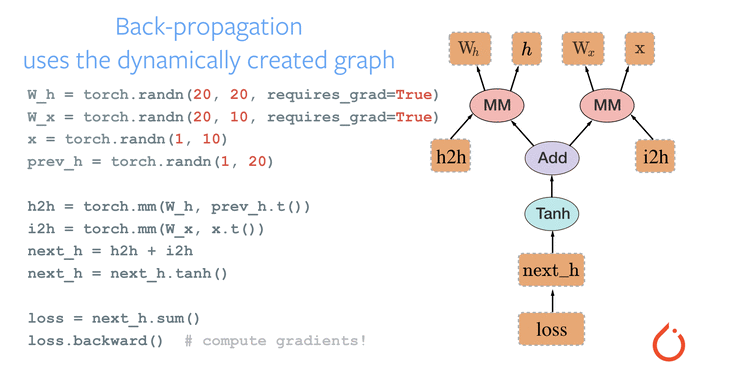

In [20]:
trace_01 = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)

trace01_cell = torch.jit.trace(trace_01, (x, h))
# What exactly has this done? It has invoked the Module, recorded the operations that 
# occurred when the 
# Module was run, and created an instance of torch.jit.ScriptModule 
# (of which TracedModule is an instance)
print(trace01_cell)
trace01_cell(x, h)

MyCell(
  original_name=MyCell
  (lin): Linear(original_name=Linear)
)


(tensor([[-0.6970,  0.9364,  0.6248, -0.0084],
         [-0.0387,  0.3723,  0.1697,  0.5496],
         [-0.4008,  0.7443,  0.4323, -0.0353]], grad_fn=<TanhBackward0>),
 tensor([[-0.6970,  0.9364,  0.6248, -0.0084],
         [-0.0387,  0.3723,  0.1697,  0.5496],
         [-0.4008,  0.7443,  0.4323, -0.0353]], grad_fn=<TanhBackward0>))

In [21]:
trace01_cell.graph

graph(%self.1 : __torch__.MyCell,
      %x : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu),
      %h : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu)):
  %lin : __torch__.torch.nn.modules.linear.Linear = prim::GetAttr[name="lin"](%self.1)
  %20 : Tensor = prim::CallMethod[name="forward"](%lin, %x)
  %11 : int = prim::Constant[value=1]() # /tmp/ipykernel_230243/3012915363.py:7:0
  %12 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::add(%20, %h, %11) # /tmp/ipykernel_230243/3012915363.py:7:0
  %13 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::tanh(%12) # /tmp/ipykernel_230243/3012915363.py:7:0
  %14 : (Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu), Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu)) = prim::TupleConstruct(%13, %13)
  return (%14)

In [23]:
print(trace01_cell.code)

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  lin = self.lin
  _0 = torch.tanh(torch.add((lin).forward(x, ), h))
  return (_0, _0)



Torch Script uses a restricted Python interpreter. This interpreter does not acquire the **Global Interpreter Lock** , and so many requests can be processed on the same instance simultaneously.

In [24]:
print(my_cell(x, h))
print(trace01_cell(x, h))

(tensor([[0.7755, 0.8072, 0.8821, 0.8820],
        [0.5719, 0.3144, 0.5850, 0.9425],
        [0.4910, 0.8903, 0.7961, 0.6960]]), tensor([[0.7755, 0.8072, 0.8821, 0.8820],
        [0.5719, 0.3144, 0.5850, 0.9425],
        [0.4910, 0.8903, 0.7961, 0.6960]]))
(tensor([[-0.6970,  0.9364,  0.6248, -0.0084],
        [-0.0387,  0.3723,  0.1697,  0.5496],
        [-0.4008,  0.7443,  0.4323, -0.0353]], grad_fn=<TanhBackward0>), tensor([[-0.6970,  0.9364,  0.6248, -0.0084],
        [-0.0387,  0.3723,  0.1697,  0.5496],
        [-0.4008,  0.7443,  0.4323, -0.0353]], grad_fn=<TanhBackward0>))


In [29]:
my_cell = MyDecCell(MyDecision())
traced_cell = torch.jit.trace(my_cell, (x, h))

print(traced_cell.dg.code)
print(traced_cell.code)

def forward(self,
    argument_1: Tensor) -> NoneType:
  return None

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  dg = self.dg
  lin = self.lin
  _0 = (lin).forward(x, )
  _1 = (dg).forward(_0, )
  _2 = torch.tanh(torch.add(_0, h))
  return (_2, _2)



/tmp/ipykernel_230243/700410003.py:3: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.sum() > 0:


Tracing does exactly what we said it would: run the code, record the operations that happen and construct a ScriptModule that does exactly that. Unfortunately, things like control flow are erased.

In [30]:
scrpted_gate = torch.jit.script(MyDecision())
my_cell = MyDecCell(scrpted_gate)
scrpted_cell = torch.jit.script(my_cell)

In [32]:
print(scrpted_gate.code)

def forward(self,
    x: Tensor) -> Tensor:
  if bool(torch.gt(torch.sum(x), 0)):
    _0 = x
  else:
    _0 = torch.neg(x)
  return _0



In [33]:
print(scrpted_cell.code)

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  dg = self.dg
  lin = self.lin
  _0 = torch.add((dg).forward((lin).forward(x, ), ), h)
  new_h = torch.tanh(_0)
  return (new_h, new_h)

